In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import tqdm
from typing import List, Tuple, Optional, Union
from src.utils.blockwise_diag_matricies import BlockwiseDiagMatrix

In [2]:
class GeneralBlockwiseDiagMatrix(nn.Module):
    def __init__(self, n_experts:int, 
                 d_1:int,
                 d_2:int,
                 k:int,
                 eps:float= 1e-4
                 ):
        super(GeneralBlockwiseDiagMatrix, self).__init__()
        #generalized blockwise diagonal matrix with n_experts different matrices of shape (d_1, d_2) each composed of k blocks
        assert d_1 % k == 0, "d_1 must be divisible by k"
        assert d_2 % k == 0, "d_2 must be divisible by k"
        
        self.k = k
        self.d_1 = d_1
        self.d_2 = d_2
        self.n_experts = n_experts
        
        self.X = nn.Parameter(torch.randn(n_experts, k, d_1 // k, d_2 // k)*eps)
        print(f"block size: {d_1 // k} x {d_2 // k}")
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #just a simple forward pass that goes over all the experts, will need to rewritten later to handle routing
        # x is of shape (...., n_experts, d_2)
        # of of (..., d_1)
        assert x.shape[-1] == self.d_2, f"input has incompatible shape {x.shape}, expected shape (..., {self.n_experts}, {self.d_2})"
        
        if x.shape[-2] == self.n_experts:
            out = torch.einsum(
                "ekij, ...ekj -> ...eki",
                self.X,
                x.view(*x.shape[:-2], self.n_experts, self.k, self.d_2 // self.k)
            ) #shape of (..., n_experts, k, d_2//k)
            return out.contiguous().view(*x.shape[:-2], self.n_experts, self.d_1)
        else:
            assert x.shape[-2] == 1, f"input has incompatible shape {x.shape}, expected shape (..., {self.n_experts}, {self.d_2}) or (..., 1, {self.d_2})"
            out = torch.einsum(
                "ekij, ...kj -> ...eki",
                self.X,
                x.view(*x.shape[:-2], self.k, self.d_2 // self.k)
            ) #shape of (..., n_experts, k, d_2//k)
            return out.contiguous().view(*x.shape[:-2], self.n_experts, self.d_1)
    
    #multiply with the core matrix
    def __matmul__(self, core: torch.Tensor) -> torch.Tensor:
        #expert core to be a matrix of shape (d_2, n)
        #or of shape (n_experts, d_2, n)
        assert core.shape[-2] == self.d_2, f"core matrix has incompatible shape {core.shape}, expected shape (*, {self.d_1}, n)"
        
        if core.dim() == 2:
            out = torch.einsum(
                "ekij,kjl->ekil",
                self.X,
                core.view(self.k, self.d_2 // self.k, -1)
            ) #shape of (n_experts, k, d_1//k, n)
            return out.contiguous().view(self.n_experts, self.d_1, -1)
        elif core.dim() == 3:
            assert core.shape[0] == self.n_experts, f"core matrix has incompatible shape {core.shape}, expected shape ({self.n_experts}, {self.d_2}, n)"
            out = torch.einsum(
                "ekij,ekjl->ekil",
                self.X,
                core.view(self.n_experts, self.k, self.d_2 // self.k,
                            -1)
            ) #shape of (n_experts, k, d_1//k, n)
            return out.contiguous().view(self.n_experts, self.d_1, -1)
        else:
            raise ValueError(f"core matrix has incompatible shape {core.shape}, expected shape (*, {self.d_2}, n)")
        
    def __rmatmul__(self, core: torch.Tensor) -> torch.Tensor:
        #expert core to be a matrix of shape (n, d_1)
        #or of shape (n_experts, n, d_1)
        assert core.shape[-1] == self.d_1, f"core matrix has incompatible shape {core.shape}, expected shape (n, {self.d_1})"
        
        if core.dim() == 2:
            out = torch.einsum(
                "lki,ekij->elkj",
                core.view(-1, self.k, self.d_1 // self.k),
                self.X
            ) #shape of (n_experts, n, k, d_2//k)
            return out.contiguous().view(self.n_experts, -1, self.d_2)
        elif core.dim() == 3:
            assert core.shape[0] == self.n_experts, f"core matrix has incompatible shape {core.shape}, expected shape ({self.n_experts}, n, {self.d_1})"
            out = torch.einsum(
                "elki,ekij->elkj",
                core.view(self.n_experts, -1, self.k, self.d_1 // self.k),
                self.X
            ) #shape of (n_experts, n, k, d_2//k)
            return out.contiguous().view(self.n_experts, -1, self.d_2)
        
    def to_dense(self) -> torch.Tensor:
        #return the dense representation of the blockwise diagonal matrix
        dense_matrices = []
        for i in range(self.n_experts):
            blocks = [self.X[i, j] for j in range(self.k)]
            dense_matrix = torch.block_diag(*blocks)
            dense_matrices.append(dense_matrix)
        return torch.stack(dense_matrices, dim=0)
    
    @property
    def params_per_expert(self) -> int:
        return self.X[0].numel()
    
        
    
    

In [8]:
class Wrapper(nn.Module):
    def __init__(self, n_experts:int,
                 d_out:int,
                 d_in:int,
                 k:Union[int, Tuple[int]],
                 d_inner:int = -1,
                 eps:float=1e-4):
        
        super(Wrapper, self).__init__()
        
        if isinstance(k, int):
            k = (k, k)
        
        #if d_inner is not given, set it to the minimum of d_in and d_out
        if d_inner == -1:
            d_inner = min(d_in, d_out)
        self.d_inner = d_inner
        
        self.B1 = GeneralBlockwiseDiagMatrix(n_experts, d_out, d_inner, k[0], 
                                             eps=eps)
        self.B2 = GeneralBlockwiseDiagMatrix(n_experts, d_inner, d_in, k[1], 
                                             eps=eps)
        
        monarch_permutation = torch.arange(d_inner).view(-1, self.B1.X.shape[-1]).T.flatten()
        # print("monarch_permutation:", monarch_permutation)
        self.permutation_matricies = nn.Buffer(
            torch.stack([monarch_permutation for _ in range(n_experts)], dim=0)
        ) #shape of (n_experts, d_inner)
        self.inverse_permutation_matricies = nn.Buffer(
            torch.argsort(self.permutation_matricies, dim=1)
        ) #shape of (n_experts, d_inner)
        self.perm_idxs = nn.Buffer(
            torch.arange(n_experts).unsqueeze(-1)
        )
        #we expect this to be the permutation of x when applied to the right, ie 
        # P @ x = x[P]
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #same logic as the wrapper multiplication
        out = self.B2(x)  #shape of (..., n_experts, d_inner)
        out = out[..., self.perm_idxs, self.permutation_matricies]  #permute along d_inner
        out = self.B1(out)  #shape of (..., n_experts, d_out)
        return out
    
    def __matmul__(self, core: torch.Tensor) -> torch.Tensor:
        #wrapper @ core 
        #multiply core with B2, then permute, then multiply with B1
        # print("core shape:", core.shape)
        out = self.B2 @ core  #shape of (n_experts, d_inner, n)
        out = out[self.perm_idxs, self.permutation_matricies, :]  #permute along d_inner
        out = self.B1 @ out  #shape of (n_experts, d_out, n)
        return out
    
    def __rmatmul__(self, core: torch.Tensor) -> torch.Tensor:
        #core @ wrapper 
        #multiply core with B1, then permute, then multiply with B2
        out = core @ self.B1  #shape of (n_experts, n, d_inner)
        assert out.shape == (self.B1.n_experts, core.shape[1], self.d_inner), \
            f"Intermediate shape mismatch: got {out.shape}, expected {(self.B1.n_experts, core.shape[1], self.d_inner)}"
        # print("out.shape after B1:", out.shape)
        # print("self.perm_idxs shape:", self.perm_idxs.shape)
        # print("self.inverse_permutation_matricies shape:", self.inverse_permutation_matricies.shape)
        # print("self.permutation_matricies:", self.permutation_matricies.shape)
        out = out[self.perm_idxs, :, self.inverse_permutation_matricies]  #permute along d_inner
        out = out.transpose(1,2)
        # print("out.shape after permute:", out.shape)
        out = out @ self.B2  #shape of (n_experts, n, d_in)
        return out
    
    @property
    def params_per_expert(self) -> int:
        return self.B1.params_per_expert + self.B2.params_per_expert
        

In [9]:
d_1,d_2,d_3 = 128, 768, 64


a = torch.randn(d_1, d_2, d_3)

idxs = torch.stack([torch.randperm(d_3) for _ in range(d_1)], dim=0)
a_permuted = a[torch.arange(d_1).unsqueeze(-1), :, idxs]
print(a_permuted.shape)

torch.Size([128, 64, 768])


In [10]:
model = "Qwen/Qwen3-30B-A3B-Base"
layer = 0
proj = "gate_proj"
device = torch.device("cuda:7")
weights_paths = glob.glob(f"../LLM_data/{model}/original_weights/layer_{layer}/mlp.expert_*.{proj}.pt")
print("Found n weights:", len(weights_paths))
weights = [torch.load(path, map_location=device)["weight"].to(torch.float32).detach() for path in weights_paths]

hessian_path = "hessian_diag/SlimPajama-627B/n_samples_512_ctx_len_8192/seed_0"
hessian_diags = [
    torch.load(w.replace("original_weights", hessian_path), map_location=device)["hessianDiag"].to(torch.float32) for w in weights_paths
]

Found n weights: 128


In [11]:
class CompressedProj(nn.Module):
    def __init__(self, weights:list[torch.Tensor], hessian_diags:list[torch.Tensor],
                 k:Union[int, Union[int, Tuple[int]]]=16, 
                 d_core:int=-1, #not used currently
                 d_wrapper_inner:Union[int, Tuple[int]]=-1,
                 device:torch.device=torch.device("cpu"),
                 eps:float=1e-4):
        super().__init__()
        self.original_weights = nn.Buffer(torch.stack(weights))  # (n_experts, out_dim, in_dim)
        self.hessian_diags = nn.Buffer(torch.stack(hessian_diags))  # (n_experts, in_dim)
        
        #calculate the loss scaling just to make sure that the losses are readable
        self.loss_scaling = torch.sum(self.original_weights**2 * self.hessian_diags.unsqueeze(1),
                                      dim=(1,2), keepdim=True)  #shape (n_experts, 1, 1)
        
        if d_core == -1:
            d_core = min(self.original_weights.shape[1], self.original_weights.shape[2])
        if isinstance(k, int):
            k = (k, k)
        if isinstance(d_wrapper_inner, int):
            d_wrapper_inner = (d_wrapper_inner, d_wrapper_inner)
            
        self.wrapper_A = Wrapper(
            n_experts=self.original_weights.shape[0],
            d_out=self.original_weights.shape[1],
            d_in=d_core,
            k=k[0],
            d_inner=d_wrapper_inner[0],
            eps = eps
        )
        self.wrapper_B = Wrapper(
            n_experts=self.original_weights.shape[0],
            d_out=d_core,
            d_in=self.original_weights.shape[2],
            k=k[1],
            d_inner=d_wrapper_inner[1],
            eps = eps   
        )
        
        self.d_core = d_core
        self.core_weight = nn.Parameter(torch.zeros(d_core, d_core)*eps)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wrapper_B(x) #shape of (..., n_experts, d_core)
        out = F.linear(out.view(-1, self.d_core), self.core_weight).view(*x.shape[:-2], 
                                                                         self.n_experts, self.d_core)
        
        out = self.wrapper_A(out)  #shape of (..., n_experts, d_out)
        return out
    
    @property
    def n_experts(self)->int:
        return self.original_weights.shape[0]
    
    def reconstruct_weight(self)->torch.Tensor:
        return self.wrapper_A @ (self.core_weight @ self.wrapper_B)  # (n_experts, out_dim, in_dim)
    
    def recon_loss(self)->torch.Tensor:
        W_recon = self.reconstruct_weight()
        # print("W_recon:", W_recon)
        # raise NotImplementedError("Debugging print statement added.")
        assert W_recon.shape == self.original_weights.shape, \
            f"Reconstructed weight shape {W_recon.shape} does not match original weight shape {self.original_weights.shape}"
        # print(self.original_weights)
        loss = (W_recon - self.original_weights)**2 * self.hessian_diags.unsqueeze(1) #shape (n_experts, out_dim, in_dim)
        #multiply by hessian diag
        # print("loss shape:", loss.shape)
        # print("loss scaling shape:", self.loss_scaling.shape)
        return torch.sum(loss/self.loss_scaling)/self.n_experts
    
    def get_new_params(self)->int:
        n_params = 0
        n_params += self.core_weight.numel()
        count_wrapper_params = lambda x: sum(p.numel() for p in x.parameters())
        
        n_params += count_wrapper_params(self.wrapper_A)
        n_params += count_wrapper_params(self.wrapper_B)
        return n_params
    
    def get_original_params(self)->int:
        return self.original_weights.numel()
    
    def get_sparsity_factor(self)->float:
        return self.get_new_params()/self.get_original_params()
    
    @property
    def params_per_expert(self) -> int:
        return self.core_weight.numel() + self.wrapper_A.params_per_expert + self.wrapper_B.params_per_expert
        
    @property
    def original_params_per_expert(self) -> int:
        return self.original_weights[0].numel()  
    
    def get_active_sparsity_factor(self) -> float:
        print("params per expert:", self.params_per_expert)
        print("original params per expert:", self.original_params_per_expert)
        return self.params_per_expert / self.original_params_per_expert
        

In [12]:
test_module = CompressedProj(weights, hessian_diags, device=device, eps=1e-1,
                             k=8,
                             d_wrapper_inner=-1
                             ).to(device)
print("sparsity factor:", test_module.get_sparsity_factor())
print("active sparsity factor:", test_module.get_active_sparsity_factor())

optimizer = torch.optim.Adam(test_module.parameters(), lr=1e-3)

# optimizer = torch.optim.AdamW(test_module.parameters(), lr=1e-3,
#                               weight_decay=1e-1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                                                    #    threshold=1e-2)

losses = []
bar = tqdm.tqdm(range(1000), desc="Training")
for step in bar:
    optimizer.zero_grad()
    loss = test_module.recon_loss()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # scheduler.step(loss)
    bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    

block size: 96 x 96
block size: 96 x 96
block size: 96 x 96
block size: 96 x 256
sparsity factor: 0.2685546875
params per expert: 1007616
original params per expert: 1572864
active sparsity factor: 0.640625


Training: 100%|██████████| 1000/1000 [01:24<00:00, 11.89it/s, loss=0.2, lr=0.001] 


In [13]:
recon_weight = test_module.reconstruct_weight().detach()
print(recon_weight)

tensor([[[ 1.5951e-03, -8.9177e-03,  9.5120e-03,  ...,  1.4247e-03,
          -1.1199e-02,  1.0148e-03],
         [ 7.8070e-03,  7.7315e-03, -1.1488e-02,  ...,  4.9858e-03,
          -5.7451e-03,  3.0388e-03],
         [ 8.2818e-03,  1.6137e-02,  3.1763e-03,  ...,  9.0442e-03,
           1.1111e-02,  3.3685e-03],
         ...,
         [-8.2251e-03, -4.7714e-03,  6.4409e-03,  ...,  1.1810e-02,
          -2.9683e-03, -1.8324e-02],
         [ 1.0254e-02,  7.4702e-03,  5.3836e-03,  ..., -1.3621e-02,
          -2.0328e-02,  9.4408e-03],
         [-1.1478e-02, -6.8769e-03, -4.6139e-03,  ...,  3.6450e-03,
           2.0510e-03,  8.8717e-03]],

        [[ 9.3432e-03, -3.5120e-02,  2.8383e-02,  ..., -4.9740e-02,
           4.5557e-03,  3.4468e-03],
         [ 7.1570e-03, -1.9476e-02,  1.0245e-02,  ...,  8.3801e-03,
          -1.0147e-02,  8.2873e-04],
         [-3.4481e-03,  2.5425e-02,  8.7634e-03,  ..., -1.6035e-02,
           3.1144e-02, -2.2695e-02],
         ...,
         [-2.7744e-02, -1

In [14]:
test_module.original_weights

tensor([[[ 9.7046e-03, -1.2939e-02,  2.0447e-03,  ...,  7.7820e-03,
          -6.7139e-03, -7.2327e-03],
         [ 2.7954e-02, -2.1362e-03, -1.5869e-02,  ...,  1.6357e-02,
          -1.0681e-03, -6.1417e-04],
         [ 2.8320e-02,  2.6489e-02,  1.6602e-02,  ...,  8.6670e-03,
           1.6846e-02, -1.6785e-04],
         ...,
         [ 9.4604e-03, -1.5381e-02,  1.7578e-02,  ...,  2.8687e-02,
          -1.7578e-02, -2.7222e-02],
         [ 3.2715e-02,  1.8799e-02,  1.2939e-02,  ..., -1.1597e-03,
          -1.7929e-03,  8.2016e-04],
         [-2.1240e-02, -1.8799e-02, -7.1411e-03,  ...,  1.1902e-02,
           2.1515e-03,  1.4771e-02]],

        [[-9.6436e-03, -3.9795e-02,  3.9551e-02,  ..., -3.0396e-02,
           2.0752e-03,  2.9419e-02],
         [-1.6212e-05, -3.2715e-02,  8.3008e-03,  ...,  1.3306e-02,
          -1.0254e-02, -1.4893e-02],
         [-8.9722e-03,  3.7354e-02,  1.2817e-03,  ...,  1.1902e-02,
          -4.2725e-03, -1.9531e-02],
         ...,
         [-3.6011e-03, -1

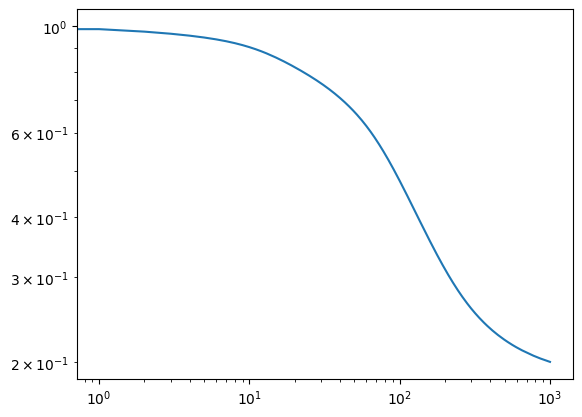

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.yscale("log")
plt.xscale("log")